In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import re
import wordbatch
from wordbatch.models import FM_FTRL
from wordbatch.models import FTRL

[nltk_data] Downloading package stopwords to C:\Users\Ekta
[nltk_data]     Gandhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("train.tsv", sep = '\t')
train = train.set_index(train.columns[0])
train.shape

(1482535, 7)

In [3]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
test = pd.read_csv("test.tsv", sep = '\t')
test = test.set_index(test.columns[0])
test.shape

(693359, 6)

In [5]:
test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [6]:
train = train[train.price > 0].reset_index(drop=True)
train.shape

(1481661, 7)

In [7]:
train['log_price'] = np.log1p(train['price'])

In [8]:
train['is_train'] = 1
test['is_train'] = 0

In [9]:
merge = pd.concat([train, test])
merge.shape

(2175020, 9)

In [10]:
merge.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,is_train
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,1
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,1
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,1
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,1
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,1


In [11]:
merge.tail()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,is_train
693354,Quartz crystal on Flint stone,1,Home/Home Décor/Home Décor Accents,NaN,NaN,0,Flint/Quartz cluster. Self mined ✨measures 3x2...,NaN,0
693355,It Cosmetics - Travel Bundle,1,Beauty/Makeup/Makeup Sets,IT Cosmetics,NaN,1,It Cosmetics travel bundle. Includes: Brow pow...,NaN,0
693356,Galaxy S8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,NaN,1,New. Free shipping Basstop case,NaN,0
693357,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,NaN,NaN,0,Floral kimono. Tropical print. Open front. Hi ...,NaN,0
693358,"FREESHIP 2 Floral Scrub Tops, medium.",2,Women/Tops & Blouses/T-Shirts,NaN,NaN,1,2 Floral scrub tops. Worn less than 5 times ea...,NaN,0


In [12]:
new = merge["category_name"].str.split("/", n = 2, expand = True)
merge["sub_category_1"] = new[0]
merge["sub_category_2"] = new[1]
merge["sub_category_3"] = new[2]
merge = merge.drop(['category_name'], axis =1)

In [13]:
merge.head()

,name,item_condition_id,brand_name,price,shipping,item_description,log_price,is_train,sub_category_1,sub_category_2,sub_category_3
0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,2.397895,1,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,1,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,1,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,1,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,3.806662,1,Women,Jewelry,Necklaces


In [14]:
merge.isnull().sum()

name                      0
item_condition_id         0
brand_name           927861
price                693359
shipping                  0
item_description          6
log_price            693359
is_train                  0
sub_category_1         9372
sub_category_2         9372
sub_category_3         9372
dtype: int64

In [15]:
merge['item_description'].fillna(value='missing',inplace=True)
merge['sub_category_1'].fillna(value='missing',inplace=True)
merge['sub_category_2'].fillna(value='missing',inplace=True)
merge['sub_category_3'].fillna(value='missing',inplace=True)
merge['brand_name'].fillna(value='unbranded',inplace=True)

In [16]:
merge.isnull().sum()

name                      0
item_condition_id         0
brand_name                0
price                693359
shipping                  0
item_description          0
log_price            693359
is_train                  0
sub_category_1            0
sub_category_2            0
sub_category_3            0
dtype: int64

In [17]:
merge['name_first'] = merge["name"].str.split(" ", expand = True)[0]
merge['name_first_count'] = merge.groupby('name_first')['name_first'].transform('count')
merge['sub_category_1_count'] = merge.groupby('sub_category_1')['sub_category_1'].transform('count')
merge['sub_category_2_count'] = merge.groupby('sub_category_2')['sub_category_2'].transform('count')
merge['sub_category_3_count'] = merge.groupby('sub_category_3')['sub_category_3'].transform('count')
merge['brand_name_count'] = merge.groupby('brand_name')['brand_name'].transform('count')
merge['name_lower_count'] = merge.name.str.count('[a-z]')
merge['name_upper_count'] = merge.name.str.count('[A-Z]')
merge['description_lower_count'] = merge.item_description.str.count('[a-z]')
merge['description_upper_count'] = merge.item_description.str.count('[A-Z]')
merge['name_len'] = merge['name'].apply(lambda x: len(x))
merge['des_len'] = merge['item_description'].apply(lambda x: len(x))
merge['name_desc_len_ratio'] = merge['name_len']/merge['des_len']
merge['desc_word_count'] = merge['item_description'].apply(lambda x: len(x.split()))
merge['mean_des'] = merge['item_description'].apply(lambda x: float(len(x.split())) / len(x)) * 10
merge['name_word_count'] = merge['name'].apply(lambda x: len(x.split()))
merge['mean_name'] = merge['name'].apply(lambda x: float(len(x.split())) / len(x))  * 10
merge['desc_letters_per_word'] = merge['des_len'] / merge['desc_word_count']
merge['name_letters_per_word'] = merge['name_len'] / merge['name_word_count']
merge['NameLowerRatio'] = merge['name_lower_count'] / merge['name_len']
merge['NameUpperRatio'] = merge['name_upper_count'] / merge['name_len']
merge['DescriptionLowerRatio'] = merge['description_lower_count'] / merge['des_len']
merge['DescriptionUpperRatio'] = merge['description_upper_count'] / merge['des_len']
merge['NamePunctCount'] = merge.name.str.count('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
merge['DescriptionPunctCount'] = merge.item_description.str.count('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
merge['NamePunctCountRatio'] = merge['NamePunctCount'] / merge['name_word_count']
merge['DescriptionPunctCountRatio'] = merge['DescriptionPunctCount'] / merge['desc_word_count']
merge['NameDigitCount'] = merge.name.str.count('[0-9]')
merge['DescriptionDigitCount'] = merge.item_description.str.count('[0-9]')
merge['NameDigitCountRatio'] = merge['NameDigitCount'] / merge['name_word_count']
merge['DescriptionDigitCountRatio'] = merge['DescriptionDigitCount']/merge['desc_word_count']
non_alphanumpunct = re.compile(u'[^A-Za-z0-9\.?!,; \(\)\[\]\'\"\$]+')
merge['weird_characters_desc'] = merge['item_description'].str.count(non_alphanumpunct)
merge['weird_characters_name'] = merge['name'].str.count(non_alphanumpunct)

In [18]:
merge["sub_category_1"] = merge["sub_category_1"].str.lower()
merge["sub_category_1"] = merge["sub_category_1"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["sub_category_1"] = merge["sub_category_1"].str.replace('\d+','')

In [19]:
merge["sub_category_2"] = merge["sub_category_2"].str.lower()
merge["sub_category_2"] = merge["sub_category_2"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["sub_category_2"] = merge["sub_category_2"].str.replace('\d+','')

In [20]:
merge["sub_category_3"] = merge["sub_category_3"].str.lower()
merge["sub_category_3"] = merge["sub_category_3"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["sub_category_3"] = merge["sub_category_3"].str.replace('\d+','')

In [21]:
merge["brand_name"] = merge["brand_name"].str.lower()
merge["brand_name"] = merge["brand_name"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["brand_name"] = merge["brand_name"].str.replace('\d+','')

In [22]:
merge["name"] = merge["name"].str.lower()
merge["name"] = merge["name"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["name"] = merge["name"].str.replace('\d+','')

In [23]:
merge["name_first"] = merge["name_first"].str.lower()
merge["name_first"] = merge["name_first"].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["name_first"] = merge["name_first"].str.replace('\d+','')

In [24]:
merge["item_description"] = merge["item_description"].str.lower()
merge["item_description"] = merge['item_description'].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','')
merge["item_description"] = merge['item_description'].str.replace('\d+','')

In [25]:
stop_words = stopwords.words('english')
merge["item_description"] = merge["item_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [26]:
df = pd.DataFrame(merge["item_description"])
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['item_description']), axis=1)
merge["item_description"] = df['tokenized_sents']

In [27]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(item_description):
    words = item_description
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
merge['item_description'] = merge['item_description'].apply(lemmatize_words)

In [28]:
merge[['polarity', 'subjectivity']] = merge['item_description'].apply(lambda x: pd.Series(TextBlob(x).sentiment))
analyzer = SentimentIntensityAnalyzer()
sentiment_scores = merge['item_description'].apply(analyzer.polarity_scores)
merge['description'] = sentiment_scores.apply(lambda x: -1 if x['neg'] > x['pos'] else (1 if x['pos'] > x['neg'] else 0))

In [29]:
merge_copy = merge.copy()

In [30]:
merge = merge.drop(['item_description'], axis=1)

In [31]:
label_encoder = preprocessing.LabelEncoder()
merge['brand_name'] = label_encoder.fit_transform(merge['brand_name'])
merge['sub_category_1'] = label_encoder.fit_transform(merge['sub_category_1'])
merge['sub_category_2'] = label_encoder.fit_transform(merge['sub_category_2'])
merge['sub_category_3'] = label_encoder.fit_transform(merge['sub_category_3'])
merge['name'] = label_encoder.fit_transform(merge['name'])
merge['name_first'] = label_encoder.fit_transform(merge['name_first'])

Model

In [32]:
test = merge.loc[merge['is_train'] == 0]
train = merge.loc[merge['is_train'] == 1]

In [33]:
test = test.drop(['is_train'], axis=1)
train = train.drop(['is_train'], axis=1)

In [34]:
train.head()

,name,item_condition_id,brand_name,price,shipping,log_price,sub_category_1,sub_category_2,sub_category_3,name_first,...,DescriptionPunctCountRatio,NameDigitCount,DescriptionDigitCount,NameDigitCountRatio,DescriptionDigitCountRatio,weird_characters_desc,weird_characters_name,polarity,subjectivity,description
0,947456,3,4940,10.0,1,2.397895,5,102,775,46134,...,0.000000,0,0,0.0,0.000000,0,0,0.000000,0.000000,0
1,1226767,3,3943,52.0,0,3.970292,1,30,215,55292,...,0.083333,0,0,0.0,0.000000,0,0,0.600000,0.725000,1
2,190573,1,4646,10.0,1,2.397895,10,103,97,14193,...,0.103448,0,2,0.0,0.068966,0,1,0.136250,0.422500,1
3,768605,1,4940,35.0,1,3.583519,3,55,410,41160,...,0.281250,0,0,0.0,0.000000,0,0,0.232121,0.598182,1
4,63283,1,4940,44.0,0,3.806662,10,58,543,7190,...,0.000000,2,0,0.5,0.000000,0,0,0.100000,0.400000,0


In [44]:
x = train.drop(['log_price', 'price'], axis=1)
y = train.loc[:, train.columns == 'log_price']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [37]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

In [38]:
alpha = 1.0 
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(x_train, y_train)
ridge_pred = ridge_model.predict(x_test)

In [39]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)

In [40]:
gbr_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
gbr_regressor.fit(x_train, y_train)
gbr_pred = gbr_regressor.predict(x_test)

In [41]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(x_train, y_train)
rfr_pred = rfr.predict(x_test)

In [42]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
sgd_model = SGDRegressor(max_iter=100000, tol=1e-3, random_state=42)
sgd_model.fit(x_train_scaled, y_train)
sgd_pred = sgd_model.predict(x_test_scaled)

In [43]:
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Gradient Boosting Regressor model', 'Random Forest Regressor','SGD Model']
y_preds_list = [lr_pred, ridge_pred, lasso_pred, gbr_pred, rfr_pred, sgd_pred]

In [60]:
def evaluate_regression_models(y_test, y_preds_list):
    num_models = len(y_preds_list)
    n = len(y_test)
    results = {}
    for i in range(num_models):
        model_name = models[i]
        y_pred = y_preds_list[i]
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - 2 - 1)
        results[model_name] = {'R-squared': '{:.2f}'.format(r2), 
                               'MSE': '{:.2f}'.format(mse), 
                               'RMSE': '{:.2f}'.format(rmse),
                               'MAE': '{:.2f}'.format(mae), 
                               'Adjusted R-squared': '{:.2f}'.format(adj_r2)}
    return results

In [45]:
results = pd.DataFrame(evaluate_regression_models(y_test, y_preds_list)).transpose()

In [46]:
sorted_results_2 = results.sort_values(by='R-squared', ascending=False)
sorted_results_2

,R-squared,MSE,RMSE,MAE,Adjusted R-squared
Random Forest Regressor,0.53,0.27,0.52,0.38,0.53
Gradient Boosting Regressor model,0.36,0.36,0.60,0.46,0.36
Linear Regression,0.13,0.49,0.70,0.54,0.13
Ridge Regression,0.13,0.49,0.70,0.54,0.13
SGD Model,0.13,0.49,0.70,0.54,0.13
Lasso Regression,0.07,0.52,0.72,0.56,0.07


In [30]:
merge = merge_copy
merge.head()

,name,item_condition_id,brand_name,price,shipping,item_description,log_price,is_train,sub_category_1,sub_category_2,...,DescriptionPunctCountRatio,NameDigitCount,DescriptionDigitCount,NameDigitCountRatio,DescriptionDigitCountRatio,weird_characters_desc,weird_characters_name,polarity,subjectivity,description
0,mlb cincinnati reds t shirt size xl,3,unbranded,10.0,1,description yet,2.397895,1,men,tops,...,0.000000,0,0,0.0,0.000000,0,0,0.000000,0.000000,0
1,razer blackwidow chroma keyboard,3,razer,52.0,0,keyboard great condition work like come box . ...,3.970292,1,electronics,computers & tablets,...,0.083333,0,0,0.0,0.000000,0,0,0.600000,0.725000,1
2,ava-viv blouse,1,target,10.0,1,adorable top hint lace key hole back ! pale pi...,2.397895,1,women,tops & blouses,...,0.103448,0,2,0.0,0.068966,0,1,0.136250,0.422500,1
3,leather horse statues,1,unbranded,35.0,1,new tag . leather horse . retail [ rm ] each ....,3.583519,1,home,home décor,...,0.281250,0,0,0.0,0.000000,0,0,0.232121,0.598182,1
4,24k gold plated rose,1,unbranded,44.0,0,complete certificate authenticity,3.806662,1,women,jewelry,...,0.000000,2,0,0.5,0.000000,0,0,0.100000,0.400000,0


In [31]:
label_binarizer = LabelBinarizer(sparse_output=True)

In [32]:
brand_name = label_binarizer.fit_transform(merge['brand_name'])
train_brand_name = brand_name[:len(train)]
test_brand_name = brand_name[len(train):]

In [33]:
sub_category_1 = label_binarizer.fit_transform(merge['sub_category_1'])
train_sub_category_1 = sub_category_1[:len(train)]
test_sub_category_1 = sub_category_1[len(train):]

In [34]:
sub_category_2 = label_binarizer.fit_transform(merge['sub_category_2'])
train_sub_category_2 = sub_category_2[:len(train)]
test_sub_category_2 = sub_category_2[len(train):]

In [35]:
sub_category_3 = label_binarizer.fit_transform(merge['sub_category_3'])
train_sub_category_3 = sub_category_3[:len(train)]
test_sub_category_3 = sub_category_3[len(train):]

In [36]:
label_encoder = preprocessing.LabelEncoder()

In [37]:
merge['name'] = label_encoder.fit_transform(merge['name'])
merge['name_first'] = label_encoder.fit_transform(merge['name_first'])

In [38]:
tfidf = TfidfVectorizer(use_idf=False, max_features=300000)
tfidf.fit(merge['item_description'])
item_description = tfidf.transform(merge['item_description'])
train_item_description = item_description[:len(train)]
test_item_description = item_description[len(train):]

In [39]:
merge = merge.drop(['is_train', 'brand_name', 'sub_category_1', 'sub_category_2','sub_category_3', 
                    'item_description', 'price', 'log_price'], axis=1)

In [40]:
scaler = MinMaxScaler()
merge_normalized = scaler.fit_transform(merge)
train_normalized = merge_normalized[:len(train)]
test_normalized = merge_normalized[len(train):]

In [41]:
sparse_train = csr_matrix(train_normalized)
sparse_test = csr_matrix(test_normalized)

In [42]:
sparse_merge_train = hstack((train_brand_name, train_sub_category_1, train_sub_category_2, train_sub_category_3, 
                             train_item_description, sparse_train)).tocsr()
sparse_merge_test = hstack((test_brand_name, test_sub_category_1, test_sub_category_2, test_sub_category_3, 
                            test_item_description, sparse_test)).tocsr()

In [54]:
y = pd.Series(y['log_price'])  

In [55]:
x_train, x_test, y_train, y_test = train_test_split(sparse_merge_train, y, test_size=0.2, random_state=42)

In [46]:
alpha = 1.0 
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(x_train, y_train)
ridge_pred = ridge_model.predict(x_test)

In [56]:
ftrl = FTRL(alpha = 0.01, beta = 0.1, L1 = 0.00001, L2 = 1.0, D = sparse_merge_train.shape[1], iters = 25, inv_link = "identity", threads = 1)
ftrl.fit(x_train, y_train)
ftrl_pred = ftrl.predict(x_test)

Total e: 520921.01172542624
Total e: 491849.7724717868
Total e: 485058.85092559224
Total e: 481229.53811023827
Total e: 478620.64546065975
Total e: 476665.17513925064
Total e: 475113.25984704716
Total e: 473833.4570937606
Total e: 472748.51675830426
Total e: 471809.272842006
Total e: 470982.6672735145
Total e: 470245.66616121115
Total e: 469581.7569138346
Total e: 468978.4869407868
Total e: 468426.47588116763
Total e: 467917.2708745412
Total e: 467445.0178558433
Total e: 467004.94822049513
Total e: 466593.35112609237
Total e: 466206.9811162798
Total e: 465842.8960186622
Total e: 465498.7484776881
Total e: 465172.3197629527
Total e: 464861.73194854124
Total e: 464565.75283004355


In [57]:
fm_ftrl = FM_FTRL(alpha=0.035, beta=0.001, L1=0.00001, L2=0.15, D=sparse_merge_train.shape[1],
                alpha_fm=0.05, L2_fm=0.0, init_fm=0.01, iters=30,
                D_fm=int(np.ceil(2 * np.sqrt(sparse_merge_train.shape[1]))), e_noise=0, inv_link="identity", threads=4)
fm_ftrl.fit(x_train, y_train)
fm_ftrl_pred = fm_ftrl.predict(x_test)

Total e: 461963.6311583284
Total e: 439109.03536892304
Total e: 431060.94928213564
Total e: 425537.7741882564
Total e: 421213.67310078704
Total e: 417592.59008680325
Total e: 414447.787031566
Total e: 411649.62770943507
Total e: 409117.0480806864
Total e: 406795.43235788343
Total e: 404646.1896137941
Total e: 402641.0904787554
Total e: 400756.83792932256
Total e: 398980.71061875543
Total e: 397298.51129400235
Total e: 395699.68387269124
Total e: 394168.4698840299
Total e: 392705.42628598283
Total e: 391301.1452667231
Total e: 389954.29942270095
Total e: 388654.93971553224
Total e: 387402.7639178667
Total e: 386187.8342693479
Total e: 385017.05208834814
Total e: 383878.0307019416
Total e: 382775.8214895735
Total e: 381702.12443321577
Total e: 380658.1423598595
Total e: 379643.1438191917
Total e: 378653.55523090163


In [58]:
models = ['Ridge', 'FTRL', 'FM_FTRL']
y_preds_list = [ridge_pred, ftrl_pred, fm_ftrl_pred]

In [61]:
results = pd.DataFrame(evaluate_regression_models(y_test, y_preds_list)).transpose()

In [62]:
sorted_results_3 = results.sort_values(by='R-squared', ascending=False)
sorted_results_3

,R-squared,MSE,RMSE,MAE,Adjusted R-squared
FM_FTRL,0.60,0.22,0.47,0.35,0.60
Ridge,0.53,0.26,0.51,0.39,0.53
FTRL,0.51,0.27,0.52,0.40,0.51


In [63]:
fm_ftrl_pred_test = fm_ftrl.predict(sparse_merge_test)

In [64]:
fm_ftrl_pred_test_price = np.exp(fm_ftrl_pred_test)
test['price'] = fm_ftrl_pred_test_price

In [69]:
test = test.drop(['is_train'], axis=1)

In [70]:
test.head(10)

,name,item_condition_id,category_name,brand_name,shipping,item_description,price
test_id,,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,11.685978
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",14.353110
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,42.691685
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,15.049997
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,11.945440
5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...,10.134457
6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...,16.381719
7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...,39.607893
8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...,51.109926


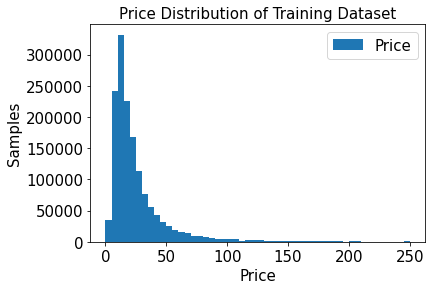

In [71]:
plt.hist(train['price'], bins=50, range=[0,250], label='Price')
plt.title('Price Distribution of Training Dataset', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

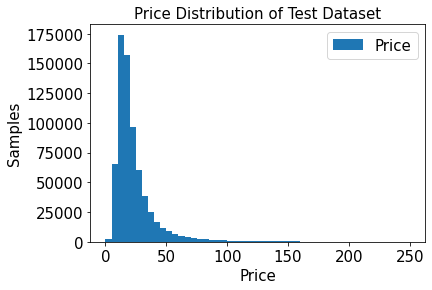

In [72]:
plt.hist(test['price'], bins=50, range=[0,250], label='Price')
plt.title('Price Distribution of Test Dataset', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [73]:
test.to_csv("final_test.tsv", sep = '\t')